### Market Price impact dynamics

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import refinitiv.data as rd

## The notebook

In this notebook, we are implementing a simple theoretical model showcasing how orders can affect price dynamics. We assume an initial stock price of  1 GBP and that there is no drift or market memory. We also assume that buyers are always willing to cross the spread that remains remains constant. We download VOD.L data for a day and we use liquidity to simulate an absorption rate of price movements due to demand instantaneous shift. We assume an exponential decay of impact exponential_decay(x0, t, gamma) and we run the calculations for n hypothetical ticks during the day.

## Open the data session

The open_session() function creates and open sessions based on the information contained in the refinitiv-data.config.json configuration file. Please edit this file to set the session type and other parameters required for the session you want to open.

In [2]:
rd.open_session()

<refinitiv.data.session.Definition object at 0x114064f40 {name='workspace'}>

### Get our data - one Line API call

Here we use our get_timeseries function to ingest hourly OHLCV for VOD.L. 

In [3]:
df = rd.get_history(universe='VOD.L', fields =["OPEN_PRC", "HIGH_1", "LOW_1", "TRDPRC_1", "ACVOL_UNS"], 
                          start='01-11-2024', end='01-12-2024', interval='hourly')
df.columns = ['open', 'high', 'low', 'close', 'volume']
df.dropna(inplace=True)
print(df)

                       open     high      low    close       volume
Timestamp                                                          
2024-01-11 07:00:00   70.49    70.49    67.19    68.58     65789703
2024-01-11 08:00:00   68.53  68.8285    68.46   68.649     29393982
2024-01-11 09:00:00   68.64   69.081    68.53     69.0     56049631
2024-01-11 10:00:00  69.019    69.02  68.6595   68.674       651976
2024-01-11 11:00:00   68.69    68.69    68.37  68.3813       740479
2024-01-11 12:00:00   68.39    68.49     68.3    68.32       725941
2024-01-11 13:00:00   68.33    68.39    68.07    68.07      3255582
2024-01-11 14:00:00   68.08    68.33    67.64  67.6835      4590197
2024-01-11 15:00:00   67.67    67.68    67.17    67.45      5418944
2024-01-11 16:00:00   67.45    67.49     64.5    67.11  13213423562


### Calculating liquidity

We now calculate liquidity using trade volume, high, low and close price. 

In [4]:
def liquidity_calc(x):
    return (x['volume'] * x['close']) / (x['high'] - x['low'])


df['liquidity'] = df.apply(liquidity_calc, axis=1)
df

,open,high,low,close,volume,liquidity
Timestamp,,,,,,
2024-01-11 07:00:00,70.49,70.49,67.19,68.58,65789703,1.367230e+09
2024-01-11 08:00:00,68.53,68.8285,68.46,68.649,29393982,5.475895e+09
2024-01-11 09:00:00,68.64,69.081,68.53,69.0,56049631,7.018919e+09
2024-01-11 10:00:00,69.019,69.02,68.6595,68.674,651976,1.241992e+08
2024-01-11 11:00:00,68.69,68.69,68.37,68.3813,740479,1.582341e+08
2024-01-11 12:00:00,68.39,68.49,68.3,68.32,725941,2.610331e+08
2024-01-11 13:00:00,68.33,68.39,68.07,68.07,3255582,6.925233e+08
2024-01-11 14:00:00,68.08,68.33,67.64,67.6835,4590197,4.502617e+08
2024-01-11 15:00:00,67.67,67.68,67.17,67.45,5418944,7.166819e+08


We also write code that scales liquidity using a sigmoid function.

In [5]:
def sigmoid_liquidity(x):
    return 1/(1+np.exp(-x))


df['norm_liquidity'] = (df['liquidity']-df['liquidity'].mean())/df['liquidity'].std()
df['sigmoid_liquidity'] = df['norm_liquidity'].apply(sigmoid_liquidity)
df

,open,high,low,close,volume,liquidity,norm_liquidity,sigmoid_liquidity
Timestamp,,,,,,,,
2024-01-11 07:00:00,70.49,70.49,67.19,68.58,65789703,1.367230e+09,-0.320839,0.420471
2024-01-11 08:00:00,68.53,68.8285,68.46,68.649,29393982,5.475895e+09,-0.276776,0.431244
2024-01-11 09:00:00,68.64,69.081,68.53,69.0,56049631,7.018919e+09,-0.260228,0.435308
2024-01-11 10:00:00,69.019,69.02,68.6595,68.674,651976,1.241992e+08,-0.334170,0.417226
2024-01-11 11:00:00,68.69,68.69,68.37,68.3813,740479,1.582341e+08,-0.333805,0.417315
2024-01-11 12:00:00,68.39,68.49,68.3,68.32,725941,2.610331e+08,-0.332703,0.417583
2024-01-11 13:00:00,68.33,68.39,68.07,68.07,3255582,6.925233e+08,-0.328075,0.418709
2024-01-11 14:00:00,68.08,68.33,67.64,67.6835,4590197,4.502617e+08,-0.330673,0.418077
2024-01-11 15:00:00,67.67,67.68,67.17,67.45,5418944,7.166819e+08,-0.327816,0.418772


After applying the function to the hourly liquidity, we plot the results.

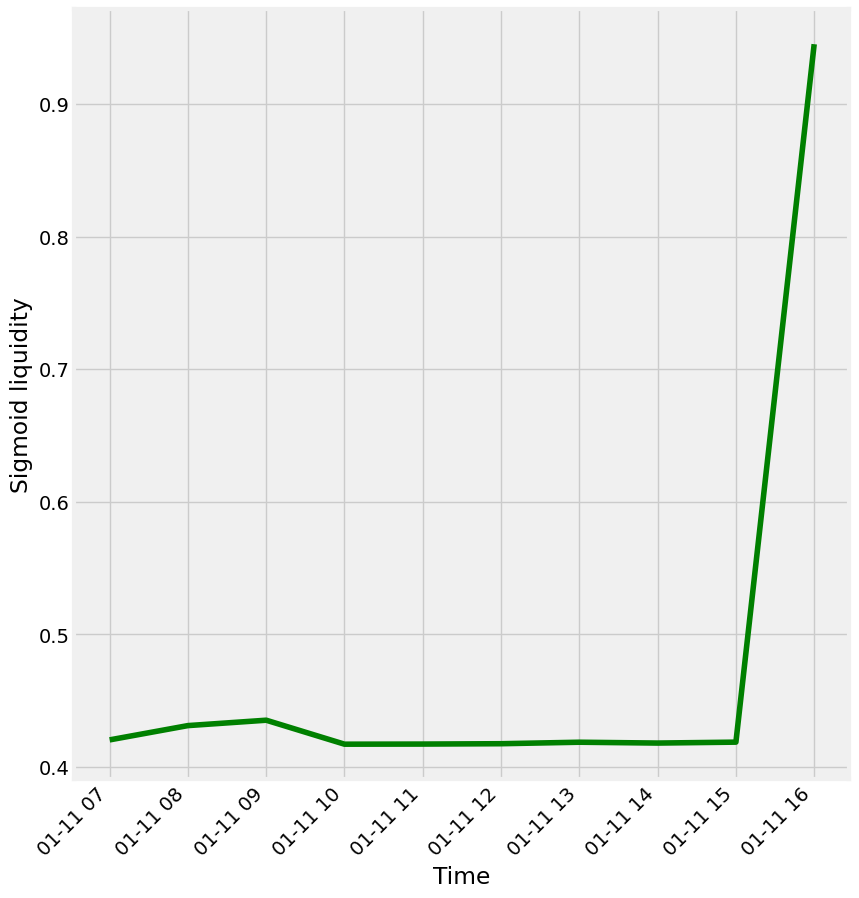

In [6]:
fig = plt.figure(figsize=(10,10))
plt.style.use('fivethirtyeight')
plt.plot(df['sigmoid_liquidity'], color='green')
plt.xlabel("Time")
plt.ylabel("Sigmoid liquidity")
plt.xticks(rotation=45, ha="right")
plt.show()

The following script applies hourly sigmoid liquidity and simulates absorption rates for a theoretical price move of 10bp.

In [7]:
bp_impact = 10
ticks = 20
initial_price = 1

def exponential_decay(x0, t, gamma=1):
    return x0 * np.exp(-gamma * t)


market = []
for ix, row in df.iterrows():
    mi = initial_price * bp_impact / 100 / 100
    mi_price = initial_price + mi
    market_hour = [mi_price] * ticks
    for t in range(1, ticks):
        market_hour[t] = initial_price + exponential_decay(mi, t, row['sigmoid_liquidity'])
    market.append(market_hour)

We can now plot how quickly the market, depending on hourly liquidity, can absorb the 10bp move. 

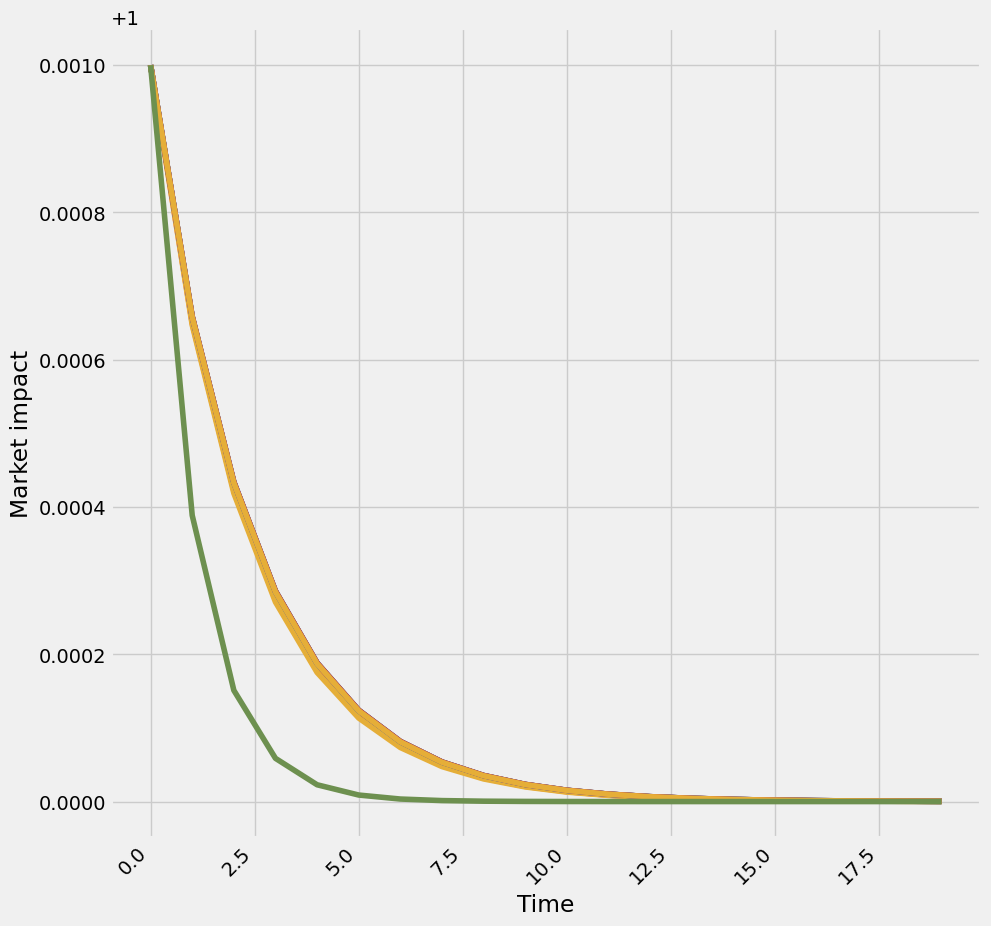

In [8]:
fig = plt.figure(figsize=(10,10))
plt.style.use('fivethirtyeight')
for hour in market:
    plt.plot(hour)
plt.xlabel("Time")
plt.ylabel("Market impact")
plt.xticks(rotation=45, ha="right")
plt.show()

Let's now write a function that will simulate a scenario where multiple participants execute a trading schedule within a 1 hour candle with a probability of crossing the spread of trade_probability. We simulate a trading flow of n ticks within the candle and assume that each trade will cause an impact in the order book of min_bp to max_bp basis points.

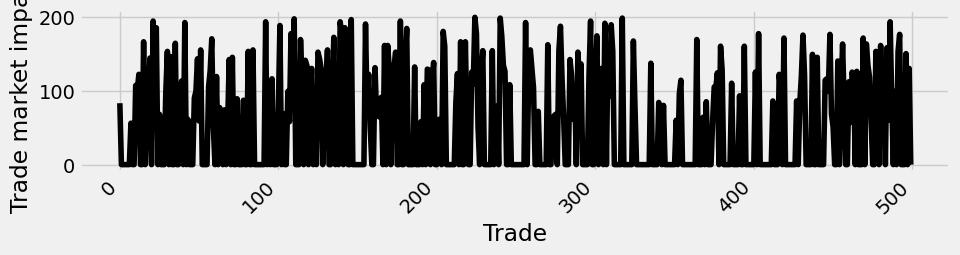

In [9]:
min_bp = 50
max_bp = 200

ticks = 500
ticks_per_hour = int(ticks / len(df))
trade_probability = 0.45

def candle_trading_flow(ticks, trade_probability, min_bp, max_bp):
    trade_flow = (np.random.rand(ticks) > 1 - trade_probability).astype(int)

    impact_flow = []
    for trade in trade_flow:
        trade *= np.random.randint(min_bp, max_bp) 
        impact_flow.append(trade)
        
    return trade_flow, impact_flow
    
    
trade_flow, impact_flow = candle_trading_flow(ticks, trade_probability, min_bp, max_bp)

fig = plt.figure(figsize=(10,2))
plt.style.use('fivethirtyeight')
plt.plot(impact_flow , color='black')
plt.xlabel("Trade")
plt.ylabel("Trade market impact")
plt.xticks(rotation=45, ha="right")
plt.show()

We simulate the trading flow within the day:

In [10]:
initial_price = 1
trade_flow_length = len(trade_flow)
market_price = [initial_price] * trade_flow_length

trade_impact = {}

hour_candle = 0 
for t in range(trade_flow_length):
    trade_impact[t] = []
    
for t1 in range(trade_flow_length):
    if ticks_per_hour % (t1+1) == 0:
        hour_candle += 1
    for t in range(t1):
        trade_impact[t1].append(0)
        
    for t2 in range(trade_flow_length - t1):
        if trade_flow[t1] == 1:
            mi = initial_price * impact_flow[t1] / 100 / 100
            market_price[t1 + t2] = (market_price[t1 + t2] + exponential_decay(mi, t2, df.iloc[hour_candle]['sigmoid_liquidity']))
            trade_impact[t1].append(exponential_decay(mi, t2, 0.05))

We can now see how this trading schedule affects the market price with hourly periods of higher liquidity being able to absorb trading flow moves resulting in price returning to its initial value. 

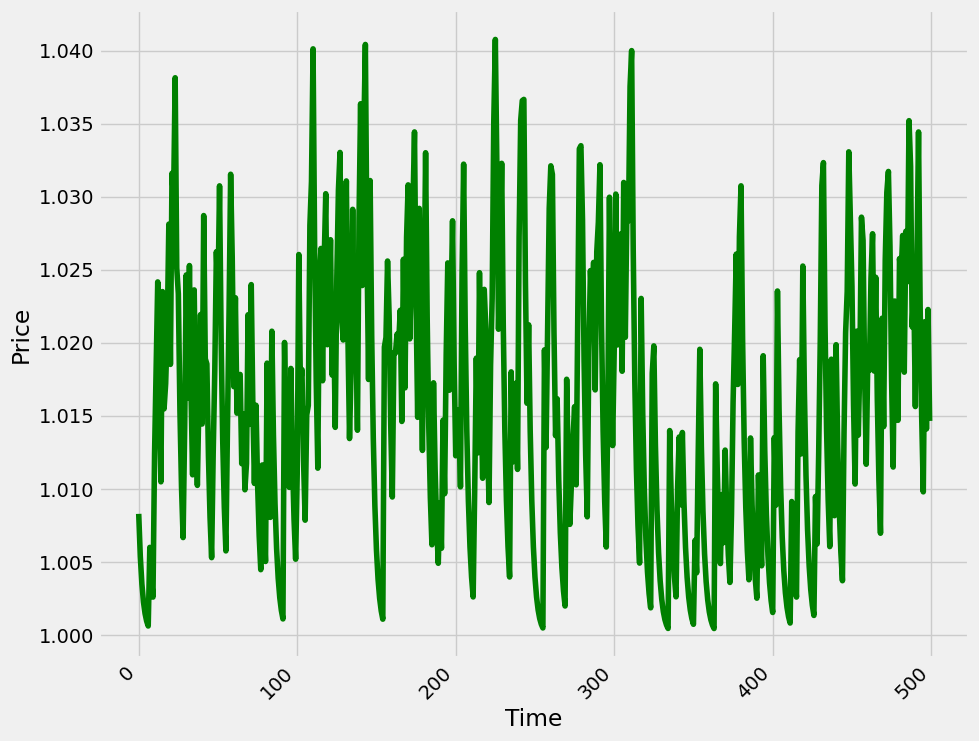

In [11]:
fig = plt.figure(figsize=(10,8))
plt.style.use('fivethirtyeight')
plt.plot(market_price, color='green')

plt.xlabel("Time")
plt.ylabel("Price")
plt.xticks(rotation=45, ha="right")
plt.show()

### Closing the session

In [16]:
rd.close_session()